# Using Llama 3.2 Vision for Function Calling

In our [previous tutorial on multimodal image processing](https://github.com/groq/groq-api-cookbook/blob/main/tutorials/multimodal-image-processing/dog-picture-storytelling-with-llava.ipynb), we explored the capabilities of [LLaVA](https://llava-vl.github.io/) (**L**arge **L**anguage-**a**nd-**V**ision **A**ssistant) by using it to analyze images of dogs and then write short childrens stories about them. In this tutorial we'll explore using Llama 3.2 Vision - a more powerful and functional multimodal model - to retrieve facts and information about dogs by calling the [API Ninjas' Dogs API](https://api-ninjas.com/api/dogs) using features gathered from the dog image.

To do so we'll use Llama 3.2 Vision in conjunction with [Groq API's JSON mode](https://console.groq.com/docs/text-chat#json-mode-object-object) to extract specific information from the provided image, such as the breed of dog or its characteristics. By doing so, we'll show how to create a pipeline for image classification and data extraction, converting unstructured images into structured data that can be easily searched, filtered, and analyzed.

### Setup

In [1]:
from groq import Groq
import base64
from IPython.display import Image 
import os
import requests
import json

To complete this tutorial, you'll need a Groq API key. If you don't already have one, you can easily create a free account on GroqCloud by clicking [here](https://console.groq.com) and generating your API key. You'll also need an API Key from [API Ninjas](https://api-ninjas.com/api), which you can also generate for free by signing up. Once you have your Groq API key, you'll need to set it as an environment variable called GROQ_API_KEY for the tutorial to work. We'll be working with the llama-3.2-11b-vision-preview model throughout this tutorial.

In [3]:
client = Groq()
model = 'llama-3.2-11b-vision-preview'
ninja_api_key = os.getenv('NINJA_API_KEY')

### Basic Llama 3.2 Vision usage

For this tutorial, we'll be using the same set of dog images from [Britannica](https://www.britannica.com/animal/dog) that we utilized in the previous tutorial. You can access these images in the Groq API cookbook repository, specifically in the [images folder](https://github.com/groq/groq-api-cookbook/tree/main/tutorials/llava-image-processing/images). We'll be encoding a local image to base64 to integrate it with Llama 3.2 Vision. This is one of two methods to use an image with the vision model - the other approach involves providing the actual URL of the image.

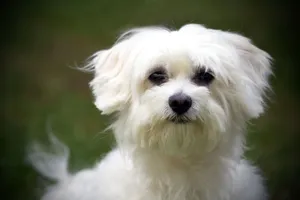

In [4]:
# Load and display the image
image_path = 'images/maltese.png'
Image(image_path)

To use locally saved images with Llama 3.2 Vision, we'll need to encode them to base64 first:

In [5]:
def encode_image(image_path):
  with open(image_path, "rb") as image_file:
    return base64.b64encode(image_file.read()).decode('utf-8')

base64_image = encode_image(image_path)

Analyzing an image with Llama 3.2 Vision using Groq API functions the same as with LLaVA. We'll make a request to the `https://api.groq.com/openai/v1/chat/completions` API endpoint, passing the image and prompt in a JSON structure that includes the image path:

In [7]:
user_prompt = 'What is the dog breed in this image?'
chat_completion = client.chat.completions.create(
    messages=[
        {
            "role": "user",
            "content": [
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpeg;base64,{base64_image}"
                    },
                },
                {"type": "text", "text": user_prompt},
            ],
        }
    ],
    model=model
)

print(chat_completion.choices[0].message.content)

The dog breed in the image is a Maltese.


However, Llama 3.2 Vision offers more functionality than LLaVA. It offers most of the functionality of any other chat model, including tool use and JSON mode (the only thing it can't do is process a system prompt). By leveraging function calling, we can utilize Llama 3.2 Vision to identify the breed of the dog in the image and use it to call the dogs API endpoint, which will return a set of facts for that breed. For a more detailed primer on function calling, check out this [Function Calling 101 cookbook](https://github.com/groq/groq-api-cookbook/blob/main/tutorials/function-calling-101-ecommerce/Function-Calling-101-Ecommerce.ipynb).

### Function Calling

First, we'll define our function to be used by Llama 3.2 Vision. This function will take in the dog breed name as a parameter and use it to call the dogs API:

In [8]:
def get_dog_facts(breed_name):
    # Format the API URL with the specific breed name for the API request
    api_url = 'https://api.api-ninjas.com/v1/dogs?name={}'.format(breed_name)
    
    # Perform a GET request to the API with the API key in the headers for authentication
    response = requests.get(api_url, headers={'X-Api-Key': ninja_api_key})
    
    # Check if the response from the server is OK (status code 200)
    if response.status_code == requests.codes.ok:
        # Extract the first dog breed match from the response JSON array
        top_match = response.json()[0] # Multiple top matches may be returned; take the first result
        return top_match
    else:
        # Return an error message with the status code and text if the request was not successful
        return "Error:", response.status_code, response.text


Next, we'll define our tools for Llama 3.2 Vision to use. Note that when defining your tool, the function description is used to determine which tool to call, and the parameter description is used to fill in the parameter of the function:

In [9]:
tools = [
    {
        "type": "function",
        "function": {
            "name": "get_dog_facts",
            "description": "Gets facts about a given dog breed",
            "parameters": {
                "type": "object",
                "properties": {
                    "breed_name": {
                        "type": "string",
                        "description": "The name of the dog breed",
                    }
                },
                "required": ["breed_name"],
            },
        },
    }
]

Now we can use the tool use functionality with Llama 3.2 Vision to extract the dog breed from the picture, and use that to call the `get_dog_facts` function. Note that the image itself is serving as the lone user message in this function call, with no additional user prompt:

In [11]:
# Function to call the LLaMA Vision Tool
def llama_vision_tool_call(client, model, base64_image, available_functions):

    chat_completion = client.chat.completions.create(
        # The user message containing the image
        messages=[
            {
                "role": "user",
                "content": [
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/jpeg;base64,{base64_image}"  # Decode the base64 image
                        },
                    },
                ],
            }
        ],
        model=model,
        tools=tools, # The tools to be used
        tool_choice="auto" # Automatically choose the tool
    )

    response_message = chat_completion.choices[0].message

    # Get the tool calls from the response message
    tool_calls = response_message.tool_calls

    # Call each available function
    for tool_call in tool_calls:
        # Get the function name from the tool call
        function_name = tool_call.function.name

        # Get the function to call from the available functions dictionary
        function_to_call = available_functions[function_name]

        # Parse the function arguments from the tool call
        function_args = json.loads(tool_call.function.arguments)

        # Call the function with the breed name
        function_response = function_to_call(
            breed_name=function_args.get("breed_name")
        )

    # Return the response from the called function
    return function_response


# Define available functions
available_functions = {
    "get_dog_facts": get_dog_facts,  # Example function to get dog facts
}

dog_breed_json = llama_vision_tool_call(client, model, base64_image, available_functions)
print(dog_breed_json)

{'image_link': 'https://api-ninjas.com/images/dogs/maltese.jpg', 'good_with_children': 3, 'good_with_other_dogs': 3, 'shedding': 1, 'grooming': 4, 'drooling': 1, 'coat_length': 1, 'good_with_strangers': 3, 'playfulness': 3, 'protectiveness': 4, 'trainability': 3, 'energy': 3, 'barking': 3, 'min_life_expectancy': 12.0, 'max_life_expectancy': 15.0, 'max_height_male': 9.0, 'max_height_female': 9.0, 'max_weight_male': 8.8, 'max_weight_female': 8.8, 'min_height_male': 7.0, 'min_height_female': 7.0, 'min_weight_male': 6.6, 'min_weight_female': 6.6, 'name': 'Maltese'}


Finally, we'll run the API output back through Llama 3.2 Vision, along with the field descriptions of the API output, so that it can provide a written assessment of the breed:

In [12]:
def assess_dog_breed(client, model, dog_breed_json):

    user_message = f"""
    Write an assessment of this dog breed given the JSON info provided; below is a description of the fields in the JSON:
    
    {dog_breed_json}
    
    Description:
    
    1. Shedding:
       - Description: How much hair the breed sheds.
       - Possible values: 1 to 5 (where 1 indicates no shedding and 5 indicates maximum shedding).
    
    2. Barking:
       - Description: How vocal the breed is.
       - Possible values: 1 to 5 (where 1 indicates minimal barking and 5 indicates maximum barking).
    
    3. Energy:
       - Description: How much energy the breed has.
       - Possible values: 1 to 5 (where 1 indicates low energy and 5 indicates high energy).
    
    4. Protectiveness:
       - Description: How likely the breed is to alert strangers.
       - Possible values: 1 to 5 (where 1 indicates minimal alerting and 5 indicates maximum alerting).
    
    5. Trainability:
       - Description: How easy it is to train the breed.
       - Possible values: 1 to 5 (where 1 indicates the breed is very difficult to train and 5 indicates the breed is very easy to train).
    
    6. Name:
       - Description: The name of the breed.
    
    7. Min Height:
       - Description: Minimum height in inches.
    
    8. Max Height:
       - Description: Maximum height in inches.
    
    9. Min Weight:
       - Description: Minimum weight in pounds.
    
    10. Max Weight:
       - Description: Maximum weight in pounds.
    
    11. Min Life Expectancy:
       - Description: Minimum life expectancy in years.
    
    12. Max Life Expectancy:
       - Description: Maximum life expectancy in years.
    
    (do not mention the JSON data, just use it to inform your response)
    """
    
    chat_completion = client.chat.completions.create(
        messages=[
            {
                "role": "user",
                "content": user_message
            }
        ],
        model=model
    )
    
    return chat_completion.choices[0].message.content

dog_breed_assessment = assess_dog_breed(client, model, dog_breed_json)
print(dog_breed_assessment)

**Assessment of the Maltese Breed**

The Maltese is a gentle, playful, and affectionate breed that makes an excellent companion for families. They are adaptable to living in small spaces, such as apartments, but require regular grooming to prevent matting and tangling of their coats.

**Temperament**

The Maltese has a friendly and outgoing personality, making them great with children and other pets. They are relatively low-maintenance and don't require excessive exercise, making them a perfect fit for busy owners. However, they do benefit from regular playtime to keep them entertained and stimulated.

**Shedding and Grooming**

As a low-shedding breed, the Maltese is hypoallergenic and suitable for owners with allergies. However, their long, silky coats require regular brushing and grooming to prevent matting and tangling. Expect to spend around 30 minutes a day on grooming, including brushing, bathing, and trimming.

**Vocalization**

The Maltese is a vocal breed, but they are not ex

Let's try it with a few additional images:

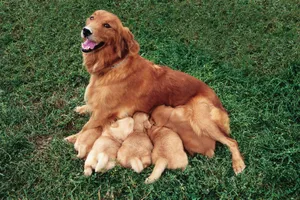

In [13]:
image_path = 'images/golden_retriever_puppies.png'
Image(image_path)

In [14]:
base64_image = encode_image(image_path)
dog_breed_json = llama_vision_tool_call(client, model, base64_image, available_functions)
dog_breed_assessment = assess_dog_breed(client, model, dog_breed_json)
print(dog_breed_assessment)

**Assessment of the Golden Retriever Breed**

**Overall Impression:**
The Golden Retriever is a loving, loyal, and energetic breed that requires regular grooming and exercise. With its high trainability, affectionate nature, and protective instincts, it makes for a wonderful family pet.

**Key Traits:**

* **Energy:** 3/5 - Average energy level, requiring regular exercise but not excessive physical activity.
* **Protectiveness:** 3/5 - Will alert strangers with a moderate level of protectiveness, making it a great breed for families.
* **Trainability:** 5/5 - Exceptionally easy to train, making it a great breed for new dog owners.
* **Barking:** 1/5 - Minimal barking, suitable for families who value quiet living.
* **Shedding:** 4/5 - Moderate shedding, requiring regular grooming to prevent matting.

**Health and Longevity:**

* **Life Expectancy:** 10-12 years - Average to above-average lifespan for a medium-sized breed.
* **Height and Weight:** The Golden Retriever stands between 23 

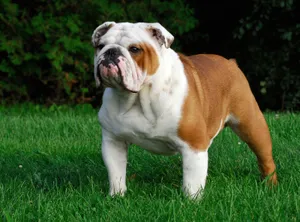

In [15]:
image_path = 'images/bulldog.png'
Image(image_path)

In [17]:
base64_image = encode_image(image_path)
dog_breed_json = llama_vision_tool_call(client, model, base64_image, available_functions)
dog_breed_assessment = assess_dog_breed(client, model, dog_breed_json)
print(dog_breed_assessment)

**American Bulldog Breed Assessment**

The American Bulldog is a sturdy and affectionate breed that makes a great companion for families. Here's an overview of its characteristics:

**Appearance:** The American Bulldog is a strong and muscular dog with a wide range of height and weight. Males can weigh up to 100 pounds and stand as tall as 28 inches, while females can weigh up to 80 pounds and stand up to 24 inches. With its short, easy-to-maintain coat and minimal shedding, it's an ideal choice for those who want a low-maintenance dog.

**Temperament:** The American Bulldog is known for its friendly and outgoing nature. It's generally good with children and other dogs, although its shedding rating of 2 indicates that it may not be suitable for families with severe allergies. While it's not particularly protective, it will alert its owner to strangers.

**Vocalization:** American Bulldogs are not excessively vocal dogs, with a barking rating of 1 out of 5. This makes them a great choic

### Conclusion

Llama 3.2 Vision showcases the versatility and power of LLMs in Groq API, enabling developers to not just process an image but unlock new capabilities through function calling. In our demo, we demonstrated the ability to use Llama 3.2 Vision to identify dog breeds from images and call an API to retrieve additional information, and then write an assessment of that breed from the information extracted. This seamless integration highlights Llama 3.2 Vision's flexibility and power, making it a valuable tool for applications like image classification, object detection, and more. We're excited to see what you build with Llama 3.2 Vision on Groq API!